<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/resnet_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title from drive
from google.colab import drive
drive.mount('/content/drive') # mount to google drive
!unzip /content/drive/MyDrive/extra/iras/google_street_view.zip -d /content # unzip google_street_view.zip
import shutil
shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

In [ ]:
# @title download
# # https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
# !gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
# !unzip /content/gsv.zip -d /content
# import shutil
# shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# clip cleaned
# https://drive.google.com/file/d/1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB/view?usp=share_link
!gdown 1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB -O gsv.zip
!unzip /content/gsv.zip -d /
# !ls
# !ls -a /content/gsv
!rm -R /content/gsv/.ipynb_checkpoints
# !rm -R /content/gsv/06/.ipynb_checkpoints

# https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Cutout(object):
    def __init__(self, p=0.5, mask_size=140, mask_color=(0, 0, 0)):
        self.p = p
        self.mask_size = mask_size
        self.mask_color = mask_color
        self.mask_size_half = self.mask_size // 2
        # offset = 1 if mask_size % 2 == 0 else 0
    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        else:
            img = np.asarray(img).copy()
            h, w = img.shape[:2] # 480x600
            cx = np.random.randint(0, w)
            cy = np.random.randint(0, h)
            xmin, xmax = cx - self.mask_size_half, cx + self.mask_size_half
            ymin, ymax = cy - self.mask_size_half, cy + self.mask_size_half
            xmin, xmax = max(0, xmin), min(w, xmax)
            ymin, ymax = max(0, ymin), min(h, ymax)
            img[ymin:ymax, xmin:xmax] = self.mask_color
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomResizedCrop(224, interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomResizedCrop((400,640), scale=(0.7, 1.0), ratio=(0.8, 1.25), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                GaussianBlur(p=1.0), # 1.0
                # Solarization(p=0.0), # 0.0
                Cutout(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
            ])

    def __call__(self, sample):
        x1 = self.transform(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1
# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



# https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
# https://arxiv.org/pdf/1708.04552.pdf
# size of the cutout region is a more important hyperparameter than the shape
# randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
# alternative randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images
def cutout(p=0.5, mask_size=16, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    # offset = 1 if mask_size % 2 == 0 else 0
    def _cutout(image):
        image = np.asarray(image).copy()
        if np.random.random() > p:
            return image
        h, w = image.shape[:2]
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return image
    return _cutout



In [1]:
# @title data
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transform = transforms.Compose(transforms.ToTensor())

# dir='/content/google_street_view'
dir='/content/gsv'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)
train_data, test_data = torch.utils.data.random_split(data, [.85,.15])



# # https://medium.com/analytics-vidhya/augment-your-data-easily-with-pytorch-313f5808fc8b
# from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# from tqdm import tqdm
# all_label_ids = torch.tensor ([label for label in df['labels']], dtype=torch.long) 5
# train_data = TensorDataset (all_label_ids)

# BATCH_SIZE = 100 # We should have 90 observation in class 0, 10 observation in class 1

# # Class weighting
# labels_unique, counts = np. unique (df['labels' ], return_counts=True)
# print("Unique labels: {}".format(labels_unique))
# class_weights = [sum(counts) / c for c in counts] # [#{class_0}, #{class_1}] 14 # Assign weight to each input sample
# example_weights = [class_weights [e] for e in df['labels']]
# sampler WeightedRandomSampler (example_weights, len (df['labels']))
# train_dataloader = DataLoader (train_data, sampler-sampler, batch_size=BATCH_SIZE) 18
# # Build your batches of sentences based on your augmented dataset
# arr_batch = []
# for step, batch in enumerate (tqdm(train_dataloader, desc="Iteration")):
# batch = tuple(t.to('cpu') for t in batch)
# label_ids = batch
# arr_batch.append(label_ids[0].detach().cpu().numpy())





from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)


batch_size = 16 # 64
num_batches=int(np.ceil(len(train_data)/batch_size))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# imshow(torchvision.utils.make_grid(images))
dataiter=None

dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.shape)
# imshow(torchvision.utils.make_grid(images))
dataiter=None

In [ ]:
%matplotlib inline 
# images, labels = next(dataiter)

# from matplotlib import pyplot as plt
image=images[0]
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()


In [1]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(pretrained=True) # 18 34 50 101 152

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# @title vit
# https://arxiv.org/pdf/2010.11929.pdf
import torch
import torch.nn as nn
from torchvision import models
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16
# model = models.vit_l_16(weights='DEFAULT') # small vit_b_16 vit_b_32 vit_l_16 vit_l_32 vit_h_14 big
# # VisionTransformer(image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim)
# num_ftrs = model.heads.head.in_features
# # num_ftrs = model.heads[-1].in_features
# model.heads = nn.Sequential(
#     # nn.Dropout(0.2),
#     nn.Linear(num_ftrs, 6, bias=False),
#     nn.Softmax(dim=1),
#     )


!pip install timm
# https://github.com/huggingface/pytorch-image-models/issues/908
import timm
# model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = timm.create_model('vit_base_patch16_224', img_size=(400, 640), pretrained=True)
# [print(x) for x in timm.list_models('vit*',pretrained=True)]
# https://huggingface.co/google/vit-base-patch16-224
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
# vit_base_patch16_224 compile,no ckpt # patch_size=16, embed_dim=768, depth=12, num_heads=12
# vit_base_patch16_384
# vit_large_patch16_224 explodesgpu # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384 # patch_size=16, embed_dim=1024, depth=24, num_heads=16

# or fine tune huge
# vit_large_patch14_224 # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384


num_ftrs = model.head.in_features
model.head = nn.Sequential(
    # nn.Dropout(0.2),
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# model.set_grad_checkpointing()

# print(model.patch_embed.grid_size) # (25, 40)
# print(model.pos_embed.shape) # [1, 1001, 768]
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

# print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')



In [ ]:
# @title inception
import torch
import torch.nn as nn
from torchvision import models
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.inception_v3(pretrained=True)
# https://discuss.pytorch.org/t/inception-v3-is-not-working-very-well/38296/16

# https://colab.research.google.com/github/CaoCharles/Deep-Learning-with-PyTorch/blob/master/2_Inception.ipynb
model.aux_logits = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]
# pytorch "inception" v3 "gradient checkpointing" https://github.com/jianweif/OptimalGradCheckpointing


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')



In [ ]:
# @title try

# # check model's input and output dimensions are correct
# X = torch.rand(64, 3, 32, 32, device=device)
X = torch.rand(16, 3, 400, 640, device=device)
# X = torch.rand(16, 3, 224, 224, device=device)
model.eval()

# 224x224
# 16x16 / 32x32 patch
# -> 14x14=196 7x7=49 seq length
# 400x640 -> 25x40=1000 seq length


logits = model(X)

# modules = [module for k, module in model._modules.items()]
# for i,x in enumerate(modules):
#     print(i,x)

# logits = checkpoint_sequential(functions=modules, segments=1, input=X)

print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(y_pred)



In [3]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential


# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            # pred = model(sx) # default

            # pred = model(sx)[0] # inception

            modules = [module for k, module in model._modules.items()]
            pred = checkpoint_sequential(functions=modules, segments=1, input=sx) # gradient checkpointing for resnet and inception only
            # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=sx)

            loss = loss_fn(pred, sy) # /4 to scale by gradient accumulation_steps
        
        scaler.scale(loss).backward()
        if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        # print("strai",batch, size, len(x)) # 0 6 1 ; 0 141 16
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


In [4]:
# @title lrfinder data
import numpy as np
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224)), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dir='/content/gsv'

# data = datasets.ImageFolder(dir, transform=transforms.ToTensor())
data = datasets.ImageFolder(dir, transform=transform)
torch.manual_seed(0)
train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
# print(len(train_data))
# print(len(test_data))

a=0.1 # 0.2 # proportion of train data to train on
train_sets,_ = torch.utils.data.random_split(train_data, [a, 1-a])
test_sets,_ = torch.utils.data.random_split(test_data, [0.5, 1-0.5])

batch_size=16#64
num_batchess=int(np.ceil(len(train_sets)/batch_size))
train_loaders = torch.utils.data.DataLoader(train_sets, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loaders = torch.utils.data.DataLoader(test_sets, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None

pth='/content/lr.pth'
torch.save(model.state_dict(), pth) # save temporary model for lr finding


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# @title lrfinder

# https://towardsdatascience.com/super-convergence-with-just-pytorch-c223c0fc1e51
# https://github.com/davidtvs/pytorch-lr-finder

# from fastai.vision.all import *
# # https://docs.fast.ai/learner.html#learner
# # learn = cnn_learner(train_loaders, model, loss_fn)
# learn = vision_learner(train_loaders, model, loss_fn)
# # vision_learner
# # https://docs.fast.ai/tutorial.vision.html
# learn.lr_find()
# # https://pypi.org/project/torch-lr-finder/


# # https://arxiv.org/pdf/1506.01186.pdf
# LR range test
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

num_iter=10 #20 # num of lr data points
start_lr= 1e-6 # 1e-6
end_lr= 1e-3 # 1e-2
# 152: 1e-7 - 1e-4


loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)

import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), optim_bits=8)


# def lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders, start_lr=1e-7, end_lr=1e-2, num_iter=10, train_batches=100, test_batches=20):
acc_list=[]
lr_list=[]
test_list=[]
for i in range(num_iter):
    model.load_state_dict(torch.load("lr.pth"))
    lr=scheduler.get_last_lr()[0]
    # lr=scheduler.get_lr()[0]
    # lr=optimizer.param_groups[0]["lr"]
    print(i,": lr = ",lr)
    lr_list.append(lr)

    loss_list = strain(train_loaders, model, loss_fn, optimizer)
    # train(train_loaders, model1, loss_fn, optimizer)
    
    scheduler.step()
    accuracy, test_loss = test(test_loaders, model, loss_fn)
    acc_list.append(accuracy)
    test_list.append(test_loss)
    # if torch.isnan(torch.tensor(test_loss)): return lr_list,acc_list,test_list
    if torch.isnan(torch.tensor(loss_list[-1])): return lr_list,acc_list,test_list
    # return lr_list,acc_list,test_list


# (end_lr/start_lr)=gamma**(num_iter)
gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
# print("gamma",gamma)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


# lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders, start_lr=0.0001, end_lr=0.1, num_iter=20, train_batches=100, test_batches=20):
# lr_list,acc_list = lrfinder(model, optimizer, loss_fn)#, train_loaders, end_lr, num_iter)
# lr_list,acc_list,test_list = lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders)# end_lr, num_iter)
lr_list,acc_list,test_list = lrfinder(model, optimizer, loss_fn, train_loaders, test_loaders, start_lr, end_lr, num_iter)
import matplotlib.pyplot as plt
# plt.plot(lr_list, acc_list)
plt.plot(lr_list, test_list)
plt.xscale('log')
plt.show()
plt.close()


In [ ]:
# @title schedulerme
import torch
import numpy as np

min_lr, max_lr = 1e-5, 1e-3 #0.5#
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)

# print(optimizer.param_groups[0]["betas"])

total_steps=97


class schedulerme():
    def __init__(self, optimizer, total_steps, min_lr, max_lr):
        self.optimizer = optimizer
        self.total_steps = total_steps
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_schedule = np.linspace(min_lr, max_lr, total_steps)
        # self.mm_schedule = np.linspace(max_mm, min_mm, total_steps)
        self.step_count = 0
        # if 'momentum' in self.optimizer.defaults: self.mb='momentum'
        # elif 'betas' in self.optimizer.defaults: self.mb='betas'

    def step(self, n=None):
        self.optimizer.param_groups[0]["lr"]=self.lr_schedule[self.step_count]
        # if self.mb=='momentum': self.optimizer.param_groups[0]["momentum"]=self.mm_schedule[self.step_count]
        # elif self.mb=='betas': #https://github.com/pytorch/pytorch/blob/master/torch/optim/lr_scheduler.py
        #     b1, b2 = self.optimizer.param_groups[0]["betas"] #https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR
        #     self.optimizer.param_groups[0]["betas"] = (self.mm_schedule[self.step_count],b2)
        self.step_count+=1

scheduler=schedulerme(optimizer,total_steps, min_lr, max_lr)

lr_list=[]
mm_list=[]
mm1_list,mm2_list=[],[]
for x in range(total_steps):
# for x in range(num_iter):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    # mm=optimizer.param_groups[0]["momentum"]
    # mm=optimizer.param_groups[0]["betas"][0]
    # mm_list.append(mm)

    # mm1,mm2=optimizer.param_groups[0]["betas"]
    # mm1_list.append(mm1)
    # mm2_list.append(mm2)

# print(mm_list)

import matplotlib.pyplot as plt
# plt.plot(lr_list)
# # plt.yscale('log')
# plt.show()
# plt.plot(mm1_list)
# plt.yscale('log')
# plt.show()
# plt.plot(mm2_list)
# plt.yscale('log')
# plt.show()


In [ ]:
# @title LR range test
# 1cycle super convergencehttps://arxiv.org/pdf/1708.07120.pdf
# # cyclic lr https://arxiv.org/pdf/1506.01186.pdf
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# one training run of the network for a few epochs

num_iter=20 #20 # num of lr data points
min_lr= 1e-7
max_lr= 1e-4 # 1e-2
# 152: 1e-7 - 1e-4


loss_fn = nn.CrossEntropyLoss()
model.load_state_dict(torch.load("lr.pth"))
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), optim_bits=8)

total_steps=int(np.ceil(num_batchess/4)*num_iter)
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ConstantLR.html
# scheduler=schedulerme(optimizer,total_steps, min_lr, max_lr)
div_factor = max_lr/min_lr
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=num_iter*2, steps_per_epoch=num_batchess, pct_start=0.45, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=100.0, three_phase=False,)

gamma = np.exp(np.log(max_lr/min_lr)/total_steps) # for scheduler step every optimizer step
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)


lr_list, acc_lst, train_lst, test_lst=[],[],[],[]

for i in range(num_iter):
    # lr=scheduler.get_last_lr()[0]
    # lr=scheduler.get_lr()[0]
    lr=optimizer.param_groups[0]["lr"]

    print(i,": lr = ",lr)
    lr_list.append(lr)

    train_ls = strain(train_loaders, model, loss_fn, optimizer, scheduler, verbose=False)
    # # train(train_loaders, model1, loss_fn, optimizer)
    
    accuracy, test_loss = test(test_loaders, model, loss_fn)
    train_lst.extend(train_ls)
    acc_lst.append(accuracy)
    test_lst.append(test_loss)

import matplotlib.pyplot as plt
# plt.plot(lr_list, acc_list)
# # plt.plot(lr_list, test_list)

plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)

plt.show()
plt.close()




===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

0 : lr =  1e-07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-05-16 09:08:48,602] torch._inductor.utils: [WARNING] not enough cuda cores to use max_autotune mode
[2023-05-16 09:08:53,413] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation
[2023-05-16 09:09:34,158] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation


Accuracy: 17.8%, Avg loss: 1.792445
1 : lr =  1.4125375446227528e-07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 17.8%, Avg loss: 1.791716
2 : lr =  1.9952623149688753e-07
Accuracy: 17.8%, Avg loss: 1.791043
3 : lr =  2.8183829312644443e-07
Accuracy: 17.8%, Avg loss: 1.789645
4 : lr =  3.981071705534955e-07
Accuracy: 17.8%, Avg loss: 1.787090
5 : lr =  5.623413251903461e-07
Accuracy: 17.8%, Avg loss: 1.783438
6 : lr =  7.943282347242762e-07
Accuracy: 18.1%, Avg loss: 1.777386
7 : lr =  1.1220184543019546e-06
Accuracy: 20.1%, Avg loss: 1.767207
8 : lr =  1.5848931924610997e-06
Accuracy: 26.4%, Avg loss: 1.749927
9 : lr =  2.2387211385683177e-06
Accuracy: 31.2%, Avg loss: 1.723603
10 : lr =  3.1622776601683445e-06
Accuracy: 34.6%, Avg loss: 1.700811
11 : lr =  4.466835921509576e-06
Accuracy: 34.0%, Avg loss: 1.691319
12 : lr =  6.309573444801849e-06
Accuracy: 33.8%, Avg loss: 1.684798
13 : lr =  8.912509381337326e-06


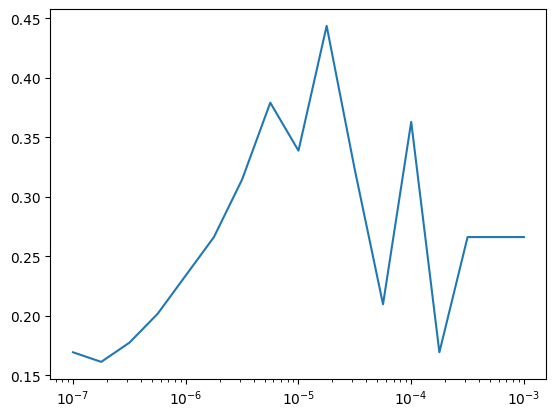

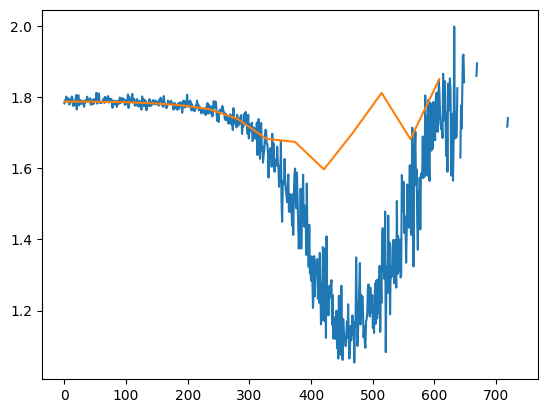

In [15]:
import matplotlib.pyplot as plt
# lr_lst = lr_list
lr_lst = lr_list[:-1]

plt.plot(lr_lst, acc_lst)
# plt.plot(lr_list, test_list)
plt.xscale('log')

plt.show()

# plt.plot(lr_lst, train_lst)
plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

Epoch 1
-------------------------------
3.000000000000005e-07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 1.792733  [    0/ 7010]
ii 1
ii 2
ii 3
ii 4
ii 5
ii 6
ii 7
ii 8
ii 9
ii 10
ii 11
loss: 1.788606  [  688/ 7010]
ii 12
ii 13
ii 14
ii 15
ii 16
ii 17
ii 18
ii 19
ii 20
ii 21
loss: 1.772604  [ 1376/ 7010]
ii 22
ii 23
ii 24
ii 25
ii 26
ii 27
ii 28
ii 29
ii 30
ii 31
ii 32
loss: 1.763449  [ 2064/ 7010]
ii 33
ii 34
ii 35
ii 36
ii 37
ii 38
ii 39
ii 40
ii 41
ii 42
ii 43
loss: 1.786797  [ 2752/ 7010]
ii 44
ii 45
ii 46
ii 47
ii 48
ii 49
ii 50
ii 51
ii 52
ii 53
ii 54
loss: 1.794284  [ 3440/ 7010]
ii 55
ii 56
ii 57
ii 58
ii 59
ii 60
ii 61
ii 62
ii 63
ii 64
loss: 1.790355  [ 4128/ 7010]
ii 65
ii 66
ii 67
ii 68
ii 69
ii 70
ii 71
ii 72
ii 73
ii 74
ii 75
loss: 1.772993  [ 4816/ 7010]
ii 76
ii 77
ii 78
ii 79
ii 80
ii 81
ii 82
ii 83
ii 84
ii 85
ii 86
loss: 1.793055  [ 5504/ 7010]
ii 87
ii 88
ii 89
ii 90
ii 91
ii 92
ii 93
ii 94
ii 95
ii 96
ii 97
loss: 1.770957  [ 6192/ 7010]
ii 98
ii 99
ii 100
ii 101
ii 102
ii 103
ii 104
ii 105
ii 106
ii 107
loss: 1.757665  [ 6880/ 7010]
ii 108
ii 109
ii 110


[2023-05-16 08:28:38,306] torch._inductor.utils: [WARNING] not enough cuda cores to use max_autotune mode
[2023-05-16 08:28:39,448] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation
[2023-05-16 08:28:54,818] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation


Accuracy: 28.1%, Avg loss: 1.747461
Epoch 2
-------------------------------
3.368759769046985e-06


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 1.769491  [    0/ 7010]
ii 111
ii 112
ii 113
ii 114
ii 115
ii 116
ii 117
ii 118
ii 119
ii 120
ii 121
loss: 1.739038  [  688/ 7010]
ii 122
ii 123
ii 124
ii 125
ii 126
ii 127
ii 128
ii 129
ii 130
ii 131
loss: 1.723312  [ 1376/ 7010]
ii 132
ii 133
ii 134
ii 135
ii 136
ii 137
ii 138
ii 139
ii 140
ii 141
ii 142
loss: 1.690142  [ 2064/ 7010]
ii 143
ii 144
ii 145
ii 146
ii 147
ii 148
ii 149
ii 150
ii 151
ii 152
ii 153
loss: 1.645477  [ 2752/ 7010]
ii 154
ii 155
ii 156
ii 157
ii 158
ii 159
ii 160
ii 161
ii 162
ii 163
ii 164
loss: 1.720136  [ 3440/ 7010]
ii 165
ii 166
ii 167
ii 168
ii 169
ii 170
ii 171
ii 172
ii 173
ii 174
loss: 1.648629  [ 4128/ 7010]
ii 175
ii 176
ii 177
ii 178
ii 179
ii 180
ii 181
ii 182
ii 183
ii 184
ii 185
loss: 1.555408  [ 4816/ 7010]
ii 186
ii 187
ii 188
ii 189
ii 190
ii 191
ii 192
ii 193
ii 194
ii 195
ii 196
loss: 1.566090  [ 5504/ 7010]
ii 197
ii 198
ii 199
ii 200
ii 201
ii 202
ii 203
ii 204
ii 205
ii 206
ii 207
loss: 1.708538  [ 6192/ 7010]
ii 208
ii 209
ii 210


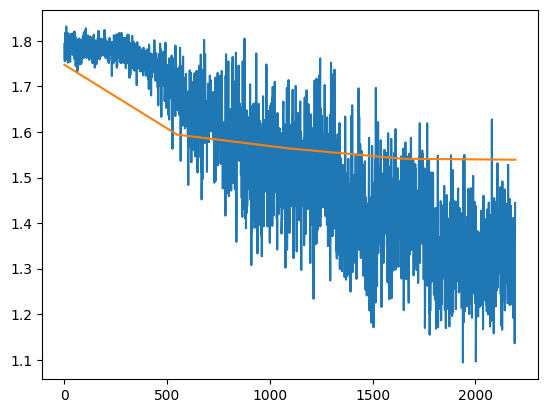

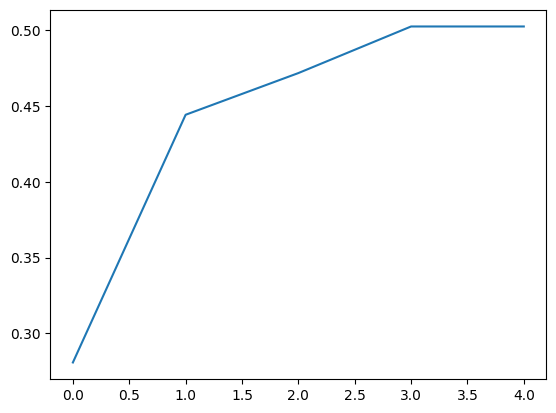

In [4]:
# @title wwwwwwwww
import time
start = time.time()
acc_lst, train_lst, test_lst=[],[],[]
loss_fn = nn.CrossEntropyLoss()


base_lr, max_lr = 3e-7, 1e-5 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

# print(num_batches)
epochs = 5 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
# gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)
# optimizer = bnb.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), optim_bits=8)
# 152 1e-5
# cnn 3e-4

div_factor = max_lr/base_lr
total_steps=int(np.ceil(num_batches/4)*epochs +1) # +1 to excluse uptick at the end of onecycle
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)



for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # train_ls = strain(train_loader, model, loss_fn, optimizer)
    correct, test_loss = test(test_loader, model, loss_fn)
    # scheduler.step()
    train_lst.extend(train_ls)
    test_lst.append(test_loss)
    acc_lst.append(correct)
print("Done!")

end = time.time()
print("time: ",end - start)

print(len(train_lst), len(test_lst))
import matplotlib.pyplot as plt
plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()


torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# resnet 18, 60/61 38.4%, 528s
# resnet 18, 58/61 39.8%, 523s
# resnet 18 compile , 58/61 40.4%, 555s
# resnet 18 compile augment , 58/61 36.4%, 1941 # augment on cpu, takes longer
# resnet 18 augment lr3e-4:3e-3, 58/61 37.7%, 1863s
# resnet 18 augment 10epoch lr1e-5:3e-4, 58/61 33.5%, 3387s
# resnet 18 compile lr1e-5:3e-4, 58/61 35.0%, 493s
# resnet 18 compile scratch lr1e-5:1e-3, 58/61 26.8%, 475s
# resnet 18 compile lr1e-5:1e-3, 55/61 47.3%, 480s
# resnet 18 compile lr1e-5:1e-3, 52/61 51.7% 503s
# resnet 18 compile lr1e-5:1e-3, unfreeze 51.0%, 550s
# resnet 18 compile lr1e-5:1e-4, unfreeze 52.7%, 518s
# resnet 34 compile lr1e-5:1e-4, unfreeze bitsadamW batch16*4
# resnet 152 compileoverhead lr3e-7:3e-6, bitsadamW batch16*4 ckpt 53.8%, 2066s
# resnet 152 from53.8% augment+cutout lr3e-7:3e-6, 53.8%, 2088s
# resnet 152 comile augment+cutout lr1e-5 /4 1epoch 48.3%, 454s
# resnet 152 comile augment+cutout lr1e-5 1epoch 48.4%, 446s
# resnet 152 comilemaxautotue augment+cutout lr1e-5 1epoch 47.7%, 448
# resnet 152 clipclean comilemax augment+cutout lr1e-5 10epoch 45.1%, 1585 *2
# resnet 152 clipclean comilemax augmax lr1e-6:3e-5 20epoch 
# resnet 152 clipclean compilemax lr3e-7:1e-5,  


# vit b16 lr1e-5 5epochs 41.3%, 466s # 4.4ram, 5.5vram
# vit l16 lr1e-5 5epochs # 32.0%, 1242s 4.5ram, 8.0vram
# vit l16 lr3e-7;1e-5 5epochs # 45.4%, 1315s 4.5ram, 8.0vram
# vit l32 lr1e-5 5epochs # .ram, .vram
# vit_large_patch16_384
# vit_base_patch16_224 maxcompile nockpt lr3e-7;1e-5 5epochs # 45.2%, 2272s 5.3ram, 11.0vram

# inception



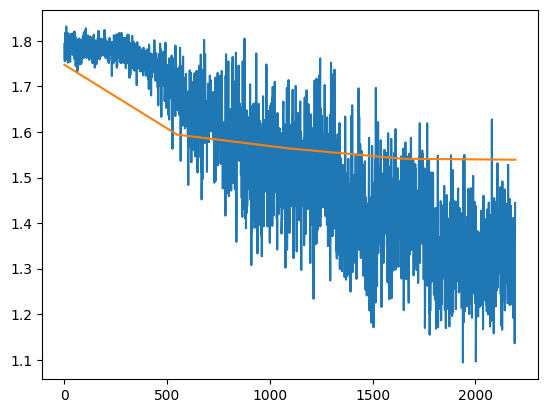

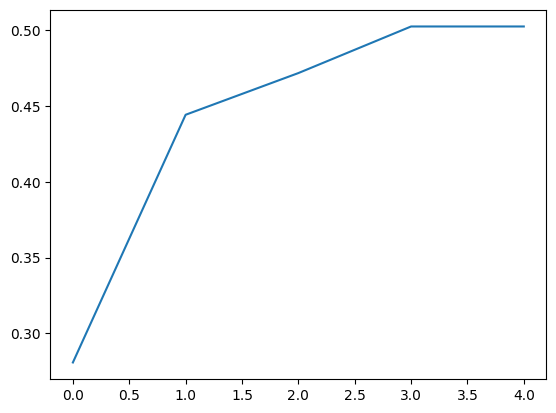

In [5]:
# correct, test_loss = test(test_loader, model, loss_fn)


plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()

10
dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'initial_lr', 'max_lr', 'min_lr', 'max_momentum', 'base_momentum'])
{'lr': 3e-07, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01}
0 lr:  3.423692637641714e-07
1 lr:  4.68736785154859e-07
2 lr:  6.768946883596837e-07
3 lr:  9.632060673557662e-07
4 lr:  1.3226685294274905e-06
5 lr:  1.7490015962784307e-06
6 lr:  2.2347564356773297e-06
7 lr:  2.7714460064220355e-06
8 lr:  3.34969334274663e-06
9 lr:  3.9593953873671245e-06
10 lr:  4.589899510697507e-06
11 lr:  5.23018963211684e-06
12 lr:  5.869078691402435e-06
13 lr:  6.495404107494945e-06
14 lr:  7.0982228095669015e-06
15 lr:  7.667002432838893e-06
16 lr:  8.191805338596656e-06
17 lr:  8.663462243236782e-06
18 lr:  9.073732422718496e-06
19 lr:  9.415447693351472e-06
20 lr:  9.682637653307385e-06
21 lr:  9.870633996652829e-06
22 lr:  9.976152077343307e-06
23 lr:  9.997348298103493e-06
24 lr:  9.933852321503204e-06
25 lr:  9.786773540441636e-06
26 lr:  9.55868169498844

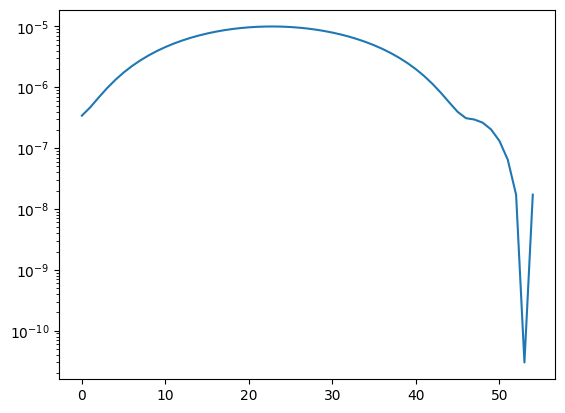

In [35]:

# num_batches=int(np.ceil(len(train_dataset)/batch_size))
num_batches=10
print(num_batches)
epochs = 10 #5 20
# num_iter= epochs*num_batches #20
num_iter= 220



base_lr, max_lr = 3e-7, 1e-5 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1


# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)

div_factor = max_lr/base_lr

# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)


print(optimizer.param_groups[0].keys())
print(optimizer.defaults)
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR



# epochs=epochs, steps_per_epoch=num_batches
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)

lr_list=[]
mm_list=[]
mm1_list,mm2_list=[],[]
# for x in range(total_steps):
for x in range(num_iter):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    print(x, "lr: ",lr)
    lr_list.append(lr)

print(mm_list)

import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()


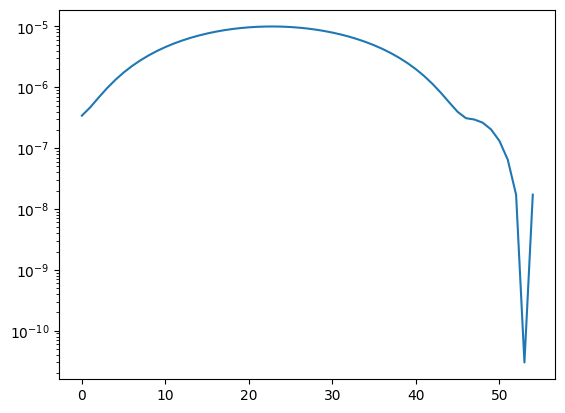

In [33]:
import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()

In [ ]:
# @title save

from google.colab import drive
drive.mount('/content/drive')

# pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/res1e-5.pth'
# pth='/content/drive/MyDrive/frame/res2e-5.pth'

# torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load(pth))
# model.load_state_dict(torch.load("model.pth"))

# # matt152 # https://drive.google.com/file/d/1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J/view?usp=sharing
# !gdown 1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J -O res152.pth
# model.load_state_dict(torch.load("res152.pth"))



Mounted at /content/drive


In [ ]:
# dir='/content/google_street_view'

# # data = datasets.ImageFolder(dir, transform=transform)
# data = datasets.ImageFolder(dir, transform=None)
# torch.manual_seed(0)
# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])

# # train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
# train_data = DatasetWrap(train_data, transform)
# test_data = DatasetWrap(test_data, transform)


# batch_size = 16 # 64
# num_batches=int(np.ceil(len(train_data)/batch_size))

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
# # data, train_data, test_data = None, None, None


# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images))
# dataiter=None


%matplotlib inline 
from matplotlib import pyplot as plt

# dataiter = iter(train_data)


# img,label = next(iter(sample_ds))
i=5
# print(len(test_data))
# img,label=test_data[i]
img,label=sample_ds[i]
print(img.shape)
# print(type(img))
model.eval()
pred=model(img.unsqueeze(0).to(device))
pred_probab = nn.Softmax(dim=1)(pred)
y_pred = pred_probab.argmax(1)
print(pred_probab)
print("pred: ",y_pred.item())
# print(img)
# image=images[0]

print("actual: ",label)
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()


In [ ]:

model.eval()
count=0
i=138
rong_lst=[]

while count<20:
    img,label=test_data[i]
    pred=model(img.unsqueeze(0).to(device))
    pred_probab = nn.Softmax(dim=1)(pred)
    y_pred = pred_probab.argmax(1)
    if y_pred.item() != label:
        print("pred: ",y_pred.item(),", actual: ",label)
        # plt.imshow(np.transpose(img, (1, 2, 0)))
        # plt.show()
        imshow(img)
        rong_lst.append(img)
        count+=1
    i+=1


# 20/137 wrong


In [ ]:
print(i)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# print(torch.stack(rong_lst).shape)
# print(len(rong_lst))
# print(rong_lst[0].shape)
imshow(torchvision.utils.make_grid(torch.stack(rong_lst),nrow=4))


In [ ]:
# @title trash
# a = []
# while(1):
#     a.append(‘1’)

# gc.collect() # Python thing

# torch.cuda.empty_cache() # PyTorch thing

# device = cuda.get_current_device() 
# device.reset()

# clear gpu memory
from numba import cuda
cuda.select_device(0)
cuda.close()
